In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import calendar
from datetime import datetime

### Chargement des datasets / Renommage de "class" en "result" (certaines méthodes Python réagissent mal au nom "class")

In [2]:
# Chargement des datasets

dataset = pd.read_csv("https://raw.githubusercontent.com/Delphine-Jean/Sources/main/Fraud_Data.csv")
countries = pd.read_csv("https://raw.githubusercontent.com/Delphine-Jean/Sources/main/IpAddress_to_Country.csv")

# Renommage de Class en Result

dataset["result"] = dataset["class"]




# Preprocessing / Features engineering

## Fonction pour amener le nom des pays du dataset secondaire vers le dataset 

---

In [3]:
# Fonction pour amener le nom des pays du dataset secondaire vers le dataset principal

def transform_ip(arg) :
    try :
        return countries.country[(countries.lower_bound_ip_address < arg) & (countries.upper_bound_ip_address > arg)].iloc[0]
    except IndexError :
        return "Pays inconnu"  
      

dataset["Pays"] = dataset.ip_address.apply(transform_ip)

# Preprocessing / Features engineering

## Fonction pour amener le nom des pays du dataset secondaire vers le dataset 

---

principal

In [4]:
#Fonction afin de transférer les noms des pays du dataset secondaire vers le dataset principal 

def transform_ip(arg) :
  try :
      return countries.country[(countries.lower_bound_ip_adress < arg) & (countries.upper_bound_ip_adress > arg)].iloc[0]
  except IndexError : 
      return "Pays inconnu"

  dataset["Pays"] = dataset.ip_adress.apply(transform_ip)

### Travail sur les variables de dates et création des variables plus détaillées 

Transformation de purchase_date et signup_date en format Datetime


In [5]:
dataset['signup_time'] = pd.to_datetime(dataset['signup_time'])
dataset['purchase_time'] = pd.to_datetime(dataset['purchase_time'])

Sur purchase_date : Création d'une nouvelle variable pour avoir un numéro de mois

Sur purchase_date : Création d'une nouvelle variable pour avoir un nom de jour puis un numéro de jour

In [10]:
from dateutil import parser
dataset['purchase_month'] = dataset['purchase_time'].dt.month 

dataset["purchase_day"] = dataset.purchase_time.apply(lambda x: calendar.day_name[x.weekday()])
dataset["purchase_day"] = dataset["purchase_day"].replace(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],[1,2,3,4,5,6,7])

 - Création d'un dataset parallèle pour : 

Y calculer **le delta entre le signup et le pruchase** (exprimé en secondes) en créant les variables "time_to_purchase" et "seconds_purchase" 

- Ensuite, cette valeur est rapatriée dans le dataset principal pour : 

**Créer une variable "bot"** qui conclue que l'on a affaire à un robot lorsque "time_to_purchase" est inférieur à 5 secondes
        


In [13]:
dataset2 = pd.read_csv("https://raw.githubusercontent.com/Delphine-Jean/Sources/main/Fraud_Data.csv")
purchase = dataset2['purchase_time'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
signup = dataset2['signup_time'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
dataset["time_to_purchase"] = purchase - signup
dataset["seconds_purchase"] = pd.DataFrame(dataset["time_to_purchase"].apply(lambda x: x.total_seconds()))
dataset["bot"] = dataset["seconds_purchase"].apply(lambda x: 1 if x <= 5 else 0)

## Visualisations pour disséquer le Dataset et créer de nouvelles variables


Le dataset comporte **9,36 % de fraude**. Comme la variable result comporte 1 (fraude) ou 0 (non fraude), il est ainsi facile de calculer une moyenne de fraude

In [14]:
dataset["result"].mean()*100

9.364577267192546

Création de deux variables qui serviront uniquement à certaines visualisations

In [15]:
cas_frauduleux = dataset.query('result == 1')
cas_non_frauduleux = dataset.query('result == 0')

Distribution des cas non frauduleux / purchase_value : on s'approche d'une **distribution en cloche**

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


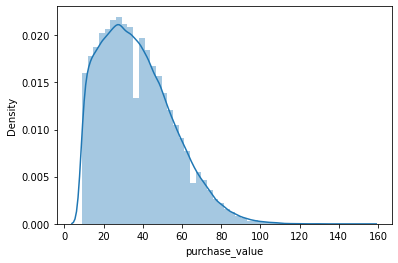

In [16]:
sns.distplot(cas_non_frauduleux.purchase_value)

Distribution des cas frauduleux / purchase_value : pas de distribution normale mais on observe des **palliers fraude / jalons de prix**

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


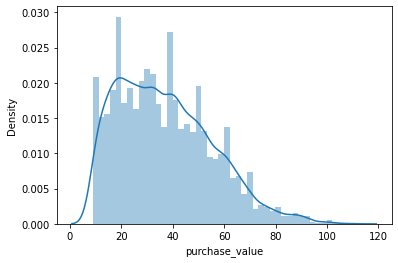

In [17]:
sns.distplot(cas_frauduleux.purchase_value)

Donc : création d'une variable "purchase_category" qui créera des **catégories** depuis "purchase_value" (0-20, 21-35, 36-60, 51 et +)

In [20]:
dataset["purchase_category"] = dataset["purchase_value"].apply(lambda x: '51-' if x>=51
                                    else "36-50" if x>=36
                                    else "21-35" if x>=21
                                    else "0-20")

## Temporalité des fraudes

La très grande majorité des fraudes ont lieu **durant le mois de janvier**


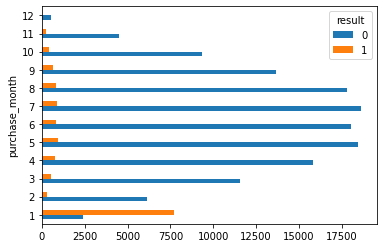

In [21]:
dataset.groupby('purchase_month').result.value_counts().unstack(1).plot.barh()

Les fraudes sont assez bien lissées sur les jours de la semaine. Quoiqu'elles ont tendeance à aller crescendo jusqu'au dimanche

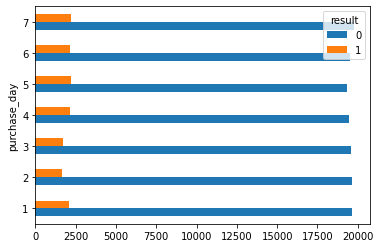

In [22]:
dataset.groupby('purchase_day').result.value_counts().unstack(1).plot.barh()

### Travail sur la variable "device" (appareil utilisé pour l'achat) afin d'en extraire des variables plus intéréssantes

- Certains devices ont servi 19 fois à effectuer des fraudes

In [23]:
decompte_device = dataset.groupby("device_id").sum()
decompte_device_2 = decompte_device.query('result > 1')
decompte_device_2 = decompte_device.sort_values(by='result', ascending=False)
decompte_device_2.head(10)

,user_id,purchase_value,age,ip_address,class,result,purchase_month,purchase_day,seconds_purchase,bot
device_id,,,,,,,,,,
NGQCKIADMZORL,4102045,840,680,4.101928e+10,19,19,21,121,3119025.0,19
EQYVNEGOFLAWK,3661993,1369,744,3.500421e+10,19,19,31,76,16107103.0,18
CQTUVBYIWWWBC,3335041,644,847,8.107377e+09,19,19,29,137,11131568.0,18
KIPFSCNUGOLDP,3409073,1160,720,1.152122e+10,19,19,20,121,723231.0,19
ZUSVMDEZRBDTX,4580050,940,1100,3.005637e+10,19,19,22,45,7073947.0,19
ITUMJCKWEYNDD,3751981,760,860,7.749515e+10,19,19,23,116,9247798.0,19
BWSMVSLCJXMCM,4286246,285,741,5.582008e+10,18,18,23,57,10263998.0,18
CDFXVYHOIHPYP,3553992,836,608,4.914672e+10,18,18,20,41,2698960.0,18
IGKYVZDBEGALB,4002848,494,741,3.421044e+10,18,18,21,112,4653283.0,18


- Certains de ces devices frauduleux ont causé des préjudices aux alentours de 1 500 $

In [24]:
decompte_device_2 = decompte_device.query('result > 1')
decompte_device_3 = decompte_device.sort_values(by='purchase_value', ascending=False)
decompte_device_3.head(10)

,user_id,purchase_value,age,ip_address,class,result,purchase_month,purchase_day,seconds_purchase,bot
device_id,,,,,,,,,,
KPAAACGRQWYIK,4113295,1458,432,3.311546e+09,17,17,21,36,9053278.0,17
UOMHJMHDVTLAS,3442096,1376,288,3.272740e+10,15,15,19,52,9429804.0,15
EQYVNEGOFLAWK,3661993,1369,744,3.500421e+10,19,19,31,76,16107103.0,18
KHHAMKJCMODJA,3222535,1320,405,5.028436e+10,14,14,16,75,4254508.0,14
TZSHXHDMKLRYJ,2871784,1288,252,8.423327e+09,13,13,16,83,5342869.0,13
RWZCXZTQUORQL,2987610,1278,810,2.306347e+10,17,17,21,123,8787771.0,17
FMSUVPZFDTJDV,2832862,1196,306,2.571607e+10,12,12,18,55,10878419.0,12
KIPFSCNUGOLDP,3409073,1160,720,1.152122e+10,19,19,20,121,723231.0,19
POEPUWBVHBKEH,2747843,1155,525,3.646773e+10,14,14,18,89,9003820.0,14


(-1.1071813255801977,
 1.1072833903119546,
 -1.10567289120639,
 1.1002701376764947)

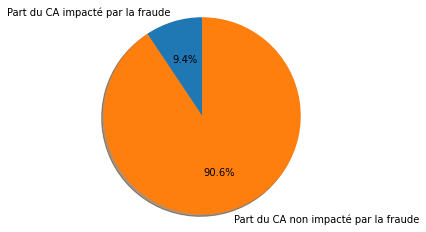

In [25]:
total_fraude = cas_frauduleux['purchase_value'].sum()
total_ventes = dataset['purchase_value'].sum()
total_ventes_reglos = total_ventes - total_fraude

labels = "Part du CA impacté par la fraude","Part du CA non impacté par la fraude"
sizes = [total_fraude,total_ventes_reglos]
explode = (0.1, 0, 0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')

In [26]:
print("Les ventes impactées par la fraude s'élèvent à :" , total_fraude,"$")
print("Pour comparaison, les ventes totales s'élèvent elle à :" , total_ventes ,"$")

Les ventes impactées par la fraude s'élèvent à : 523488 $
Pour comparaison, les ventes totales s'élèvent elle à : 5581378 $


- Donc création dans le dataset principal d'une **nouvelle variable "frequence_utilisation"** qui indique le nombre de fois où le device est utilisé pour effectuer un achat sur le site 

In [27]:
devices_reccurents = pd.DataFrame(dataset.groupby(by = "device_id").device_id.count())
devices_reccurents.rename(columns={"device_id": "frequence_utilisation"}, inplace=True)
devices_reccurents.reset_index(level=0, inplace= True) 

dataset = dataset.merge(devices_reccurents, on= "device_id")

### Observation des pays où il y a le plus de cas fraduleux : USA surreprésentés

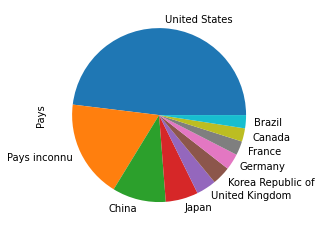

In [28]:
dataset.Pays.value_counts()[dataset.Pays.value_counts() >2000].plot(kind="pie")

Il sera difficile de faire tourner un modèle avec autant de pays (surtout un Random Forest) dans la colonne "Pays". Donc il y a besoin de simplifier cette variable. 

- On créé donc une **nouvelle variable** **"taux_de_fraude_pays"** qui indiquera pour chaque pays un taux Transaction frauduleuse / transaction non frauduleuses. Cela en calculant pour chaque pays la moyenne dans la colonne "result" (pour rappel : 1 vaut fraude et 0 vaut transaction valide)

In [29]:
score_pays = pd.DataFrame(dataset.groupby(by="Pays").mean()["result"].sort_values(ascending = False))
score_pays["taux_de_fraude_pays"] = score_pays["result"]

dataset = dataset.merge(score_pays.drop("result", axis = 1), left_on= "Pays", right_index = True)

- Certains pays ont des taux de fraude de 1, ou proches de 0.5

In [30]:
score_pays.head()

,result,taux_de_fraude_pays
Pays,,
Turkmenistan,1.000000,1.000000
Namibia,0.434783,0.434783
Sri Lanka,0.419355,0.419355
Luxembourg,0.388889,0.388889
Virgin Islands (U.S.),0.333333,0.333333


- La distribution des fraudes indique un pic important aux alentours des 5%, 10 


%, 12 % et 20 % de fraude.  

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


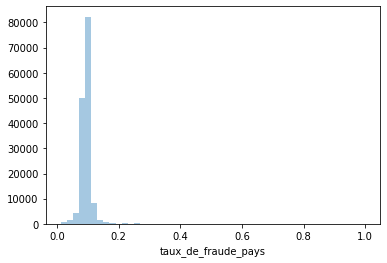

In [31]:
fraude_constatee = dataset.query('taux_de_fraude_pays > 0.0')
sns.distplot(fraude_constatee["taux_de_fraude_pays"],kde=False)

- Donc, une variable "groupe_pays_fraude" sera créé avec les seuils de 5 %, 10 %, 12 % et 20 % (toujours dans l'optique de faciliter l'apprentissage du modèle)

In [33]:
dataset["groupe_pays_fraude"] = dataset["taux_de_fraude_pays"].apply(lambda x: "20-" if x>=21 
                         		      	else "11-20" if x>=11
                         		      	else "6-10" if x>=6
                         		      	else "0-5") 

### Travail sur la variable "age"

La variable "age" contient un certains nombre de pics qui constitueront autant de seuils afin de les classer en catégories et ainsi simplifier le travail du modèle par la suite

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


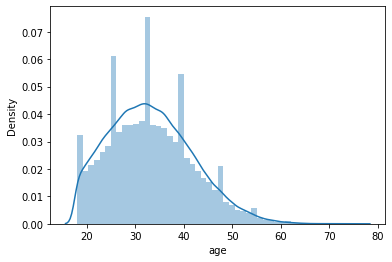

In [34]:
sns.distplot(dataset.age)

In [35]:
dataset["categorie_age"] = dataset["age"].apply(lambda x: "41-" if x>=41
                         		      	else "33-40" if x>=33
                         		      	else "26-32" if x>=26
                         		      	else "0-25") 

## Nettoyage du dataset et dernières opérations avant entraînement du modèle

Après toutes ces étapes, les variables suivantes ont été créées dans le dataset : 

- "result" pour remplacer "class"
- "Pays" pour rappatrier le bon pays pour la bonne IP
- "purchase_month" pour le mois de l'achat
- "purchase_day" pour le numéro du jour où l'achat a été effectué 
- "time_to_purchase" pour compter le temps entre le signup et le purchase
- "seconds_purchase" pour compter ce même temps mais en secondes
- "bot" pour flaguer les cas où le delta signup / purchase est inférieur à 5 secondes
- "purchase_category" pour classer le montant des achats en plusieurs catégories
- "frequence_utilisation" pour compter le nombre de fois où un même numéro de device à servi à faire un achat
- "taux_de_fraude_pays" pour indiquer le taux de fraude pour un pays donné
- "groupe_pays_fraude" pour classer les pays selon leur niveau d'exposition à la fraude
- "categorie_age" pour classer les âges en catégories issues de la distribution des âges dans le dataset


Donc, toutes les variables ne sont pas utiles (car redondantes / et peuvent créer de la colinéarité en cas de modèle linéaire) et certaines d'entre elles peuvent être supprimées :

- "user_id"
- "signup_time"
- "purchase_time"
- "purchase_value"
- "device_id"
- "ip_address"
- "class"
- "Pays"
- "time_to_purchase"
- "seconds_purchase"
- "taux_de_fraude_pays"


In [36]:
dataset_2 = dataset
dataset_2 = dataset_2.drop(["age","user_id", "signup_time","purchase_time","purchase_value","device_id","ip_address","class","Pays","time_to_purchase","seconds_purchase","taux_de_fraude_pays"],axis=1)

On dummyfie les variables catégorielles (moins nombreuses grâce au preprocessing donc)


In [38]:
dataset_2 = pd.get_dummies(dataset_2, drop_first=True) 

**Le dataset suivant servira pour l'apprentissage ressemble donc à cela**

In [39]:
dataset_2.head()

,result,purchase_month,purchase_day,bot,frequence_utilisation,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_M,purchase_category_21-35,purchase_category_36-50,purchase_category_51-,categorie_age_26-32,categorie_age_33-40,categorie_age_41-
0,0,4,6,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0
61,0,4,4,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0
70,0,8,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1
84,0,1,1,0,2,1,0,0,1,0,0,0,0,0,1,0,0,1
91,0,9,7,0,2,0,1,0,0,0,0,0,1,0,0,0,1,0


In [40]:
dataset_2.columns

Index(['result', 'purchase_month', 'purchase_day', 'bot',
       'frequence_utilisation', 'source_Direct', 'source_SEO',
       'browser_FireFox', 'browser_IE', 'browser_Opera', 'browser_Safari',
       'sex_M', 'purchase_category_21-35', 'purchase_category_36-50',
       'purchase_category_51-', 'categorie_age_26-32', 'categorie_age_33-40',
       'categorie_age_41-'],
      dtype='object')

In [41]:
dataset_2.shape

(151112, 18)

#Entraînement du modèle

Création de X et y, et split du dataset en train/test

In [42]:
y = dataset_2.iloc[:,0]
X = dataset_2.iloc[:,1:]

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

###Premier entraînement avec une Regression Logistique

In [44]:
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()

sc_x_fit = sc_x.fit(X_train)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)

In [45]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

**Un premier score de 0.95....pas mal. Voyons ca de plus près...**

In [46]:
logistic.score(X_test, y_test)

0.9577804982959998

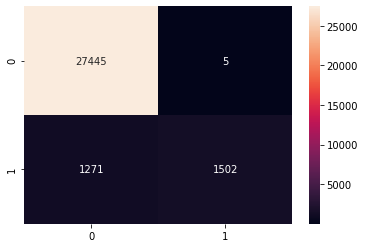

In [47]:
y_pred = logistic.predict(X_test)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")

### Tentons d'entraîner notre jeu de test sur plusieurs modèles tout en faisant du Stacking :-)

In [48]:
pip install vecstack

  Created wheel for vecstack: filename=vecstack-0.4.0-cp36-none-any.whl size=19880 sha256=d1bf07cdc61923e3053232a96af9207fcd1566c0291d0ecda886d651d968fd69
  Stored in directory: /root/.cache/pip/wheels/5f/bb/4e/f6488433d53bc0684673d6845e5bf11a25240577c8151c140e
Successfully built vecstack


In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from xgboost import XGBClassifier
from vecstack import stacking




models = [
    LogisticRegression(),
    
    KNeighborsClassifier(n_neighbors=5,
                        n_jobs=-1),
        
    RandomForestClassifier(random_state=0, n_jobs=-1, 
                           n_estimators=100, max_depth=3),
        
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                  n_estimators=100, max_depth=3),
    
    svm.SVC(kernel="linear")
]

In [50]:
S_train, S_test = stacking(models,                   
                           X_train, y_train, X_test,   
                           regression=False, 
     
                           mode='oof_pred_bag', 
       
                           needs_proba=False,
         
                           save_dir=None, 
            
                           metric=accuracy_score, 
    
                           n_folds=4, 
                 
                           stratified=True,
            
                           shuffle=True,  
            
                           random_state=0,    
         
                           verbose=2)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [5]

model  0:     [LogisticRegression]
    fold  0:  [0.95751580]
    fold  1:  [0.95589306]
    fold  2:  [0.95552908]
    fold  3:  [0.95569453]
    ----
    MEAN:     [0.95615812] + [0.00079438]
    FULL:     [0.95615813]

model  1:     [KNeighborsClassifier]
    fold  0:  [0.95698640]
    fold  1:  [0.95529747]
    fold  2:  [0.95549600]
    fold  3:  [0.95542982]
    ----
    MEAN:     [0.95580242] + [0.00068730]
    FULL:     [0.95580243]

model  2:     [RandomForestClassifier]
    fold  0:  [0.95761506]
    fold  1:  [0.95599232]
    fold  2:  [0.95579379]
    fold  3:  [0.95592615]
    ----
    MEAN:     [0.95633183] + [0.00074431]
    FULL:     [0.95633184]

model  3:     [XGBClassifier]
    fold  0:  [0.95761506]
    fold  1:  [0.95599232]
    fold  2:  [0.95579379]
    fold  3:  [0.95592615]
    ----
    MEAN:     [0.95633183] + [0.00074431]
    FULL:  

### Plusieurs modèles ont été testés : RegLog, KNN, Random Forest, etc.

#### Random Forest donne des résultats intéréssants : tentons de l'approfondir

In [51]:
forest = RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=100, max_depth=3)
    
forest = forest.fit(X_train, y_train)

y_pred_2 = forest.predict(X_test)

forest.score(X_test, y_test)

0.957912847831122

#### Lançons une GridSearch pour trouver les meilleurs paramètres pour la Random Forest : en mettant des paramètres proches de ceux qui donnaient un score de 0.95

In [57]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'criterion': ['gini','entropy'],
    'max_depth': [3, 5, 7, 10],
    'max_features': [2, 3],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [100, 110, 90, 105]}
    

forest = RandomForestClassifier()
grid_search = GridSearchCV(estimator = forest, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [58]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 32.4min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 46.2min
[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed: 58.0min finished


{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

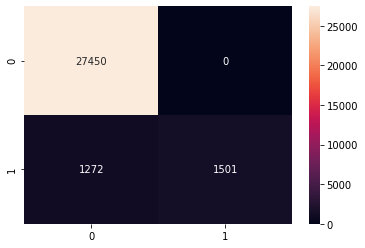

In [59]:
y_pred_grd = grid_search.predict(X_test)

cm2 = confusion_matrix(y_test, y_pred_grd)
sns.heatmap(cm2, annot=True, fmt="d")

# Recommandations

Les utilisateurs qui peuvent être classés comme risqués sont : 

- Ceux qui utilisent des bots pour effectuer des achats. Donc il est nécéssaire de bloquer les transactions dont le signup et le pruchase sont trop rapprochés dans le temps (tous les cas où le delta s'élève à 1 seconde)

- Ceux dont l'adresse IP renvoie vers des pays exotiques et dont le taux de fraude (transactions frauduleuses / transactions conformes) est supérieur à 10 %. A fortiori si peu d'utilisateurs proviennent du pays en question, ce taux de fraude devient une metric fondamentale. 

- Ceux dont le device a été flagué comme frauduleux et qui effectuent de nombreux achats (parfois sur plusieurs pays) frauduleux


Donc : 

- A minima, un système de ban s'impose. Pour bannir : les adresses IP frauduleuses, les devices reconnus comme frauduleux. 

- Aussi, il est nécéssaire d'imposer un système de sécurité supplémentaire lorsque le pays de connexion est reconnu comme à risque. 


----


Concernant l'expérience utilisateur dans une démarche où le modèle serait mis en production : 

- Le modèle pourrait être intégré dans une stratégie plus générale de détéction de fraude à l'achat. 

- Chaque transaction devrait être mis en attente le temps que le modèle ait automatiquement considéré si l'achat est sur ou non (avec pourquoi pas l'appui d'un mail de confirmation qui pourra ainsi écarter les bots non sophistiqués). Si le client est considéré comme clean, la transaction peut se poursuivre. Autrement, la transaction est avortée. 

- Si le modèle est en ligne, il pourra continuer à s'enrichir des nouveaux cas de fraude détéctés et ainsi devenir plus performant sur le temps. 